In [289]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pylab as plt
import ruptures as rpt

In [290]:
import pandas as pd
import os

def load_df(asset_name: str, base_dir: str = None):
    if base_dir is None:
        # Get the current working directory and locate the 'crypto_qts_data_processed' folder
        base_dir = os.path.join(os.getcwd(), 'crypto_qts_data_processed')

    file_path = os.path.join(base_dir, f"{asset_name}_price_processed.parquet")

    if os.path.exists(file_path):
        return pd.read_parquet(file_path)
    else:
        raise FileNotFoundError(f"File not found: {file_path}")





In [291]:
import numpy as np
def segmentation_rule(crypto: str,
                      jump = 5,
                      pen = 30, plot = False, dates= False):
    df = load_df(crypto)
    daily = df.loc[::24]
    daily['returns'] = daily['price_close'].pct_change()**2
    daily = daily[['price_close']]

    c = rpt.Pelt(model = "rbf", min_size=3, jump=jump).fit(daily.values)
    model = c.predict(pen=pen)

    if plot:
        fig, ax = plt.subplots()
        ax.plot(daily.values, color = 'b')
        for r in model:
            ax.axvline(x = r, color = 'r', linestyle = '--')



    if dates:

        y = daily.reset_index()
        dates =[]
        dates.append(df.index[0])
        for m in model:
            m = m-1
            dates.append(y.loc[m,'index'])
    return dates






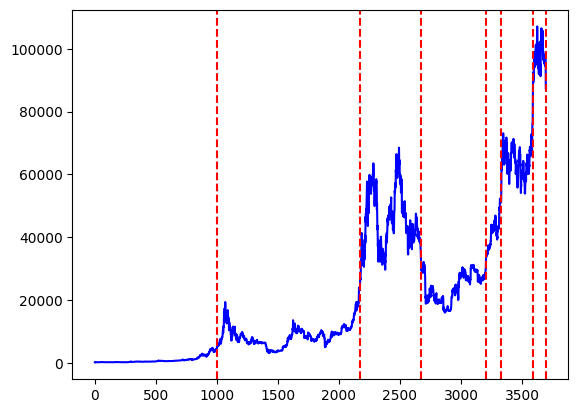

In [261]:
#See the plot, if you return dates, it'll show you the dates segmented
dates = segmentation_rule(crypto= 'BTC',
                      jump = 5,
                      pen = 30, plot = True, dates= True)

In [294]:
def sparse_crypto(crypto = 'crypto',
                      jump = 5,
                      pen = 30,
                    plot = False,
                    dates = True):


    dates = segmentation_rule(crypto = crypto,
                      jump = jump,
                      pen = pen, plot = plot, dates = True)

    dfs = {}
    for j in range(len(dates)-1):
        start = dates[j]
        end = dates[j+1]
        df = load_df(crypto).copy()
        df.reset_index(inplace = True)
        df_filtered = df[(df['index']>= start) & (df['index']< end)]
        df_filtered['start_date'] = start
        df_filtered['end_date'] = end

        dfs[f"df_{j}"] = df_filtered





    return dfs


In [295]:
# Each segmented df is stored in a dictionary
btc_dfs = sparse_crypto(crypto = 'BTC',
                      jump = 5,
                      pen = 30,
                    plot = False,
                    dates = True)

In [296]:
def summary_table(crypto = 'BTC',
                      jump = 5,
                      pen = 30,
                    plot = False,
                    dates = True):
    dfs = sparse_crypto(crypto = crypto,
                      jump = jump,
                      pen = pen ,
                    plot = plot,
                    dates = True)

    dfs_summary = {}

    for k, v in dfs.items():
        mean = v['price_close'].mean()
        stdv = v['price_close'].std()
        start_date = (v['start_date'].values[1])
        end_date = (v['end_date'].values[1])


        dfs_summary[k] = {'mean':mean, 'stdv':stdv, 'start_date':start_date, 'end_date':end_date}

    dfs_summary_df = pd.DataFrame.from_dict(dfs_summary, orient='index')

    return dfs_summary_df





In [297]:
#Summary of each df
summary_table(crypto = 'BTC',
                      jump = 5,
                      pen = 30,
                    plot = False,
                    dates = True)

,mean,stdv,start_date,end_date
df_0,929.458402,1045.801566,2015-01-14 17:00:00,2017-10-09 17:00:00
df_1,8606.897153,3389.097937,2017-10-09 17:00:00,2020-12-22 17:00:00
df_2,45439.144218,9335.616547,2020-12-22 17:00:00,2022-05-06 17:00:00
df_3,24197.495011,4546.286601,2022-05-06 17:00:00,2023-10-23 17:00:00
df_4,41710.701133,4856.425256,2023-10-23 17:00:00,2024-02-25 17:00:00
df_5,64413.884960,4716.358386,2024-02-25 17:00:00,2024-11-11 17:00:00
df_6,97602.851482,4157.387892,2024-11-11 17:00:00,2025-02-25 17:00:00


In [298]:
from datetime import timedelta
import numpy as np
def normalize_data(crypto = 'BTC'):

    zscore_data = summary_table(
                    crypto = crypto,
                    jump = 5,
                    pen = 30,
                    plot = False,
                    dates = True)



    dfs = sparse_crypto(crypto = crypto,
                      jump = 5,
                      pen = 30,
                    plot = False,
                    dates = True)

    for k,v in dfs.items():

        start_date = v['start_date'].values[0]

        mean = zscore_data[zscore_data['start_date']==start_date]['mean'].values[0]
        std = zscore_data[zscore_data['start_date']==start_date]['stdv'].values[0]

        v['normalized_price'] = (v['price_close'] - mean)/std
        v['returns_normalized'] = v['normalized_price'].pct_change()




    return dfs


In [299]:
def concat_dicts(dates, crypto = 'BTC'):
    dfs = normalize_data(crypto = crypto)

    token = load_df(crypto)

    y = token.loc[:dates[0]]



    for i in range(len(dfs)):

        y = pd.concat([y, dfs[f'df_{i}']], ignore_index = True)

    return y


In [305]:
concat_dicts(dates, crypto = 'BTC')

,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count,index,start_date,end_date,normalized_price,returns_normalized
0,2015-01-14 16:07:05+00:00,2015-01-14 16:55:16+00:00,173.93,197.97,110.20,185.91,1.050000,105.0,NaT,NaT,NaT,NaN,NaN
1,2015-01-14 16:07:05+00:00,2015-01-14 16:55:16+00:00,173.93,197.97,110.20,185.91,1.050000,105.0,2015-01-14 17:00:00+00:00,2015-01-14 17:00:00+00:00,2017-10-09 17:00:00+00:00,-0.710984,NaN
2,2015-01-14 16:07:05+00:00,2015-01-14 16:55:16+00:00,173.93,197.97,110.20,185.91,1.050000,105.0,2015-01-14 18:00:00+00:00,2015-01-14 17:00:00+00:00,2017-10-09 17:00:00+00:00,-0.710984,0.000000
3,2015-01-14 18:50:59+00:00,2015-01-14 18:50:59+00:00,186.00,186.00,186.00,186.00,0.015362,1.0,2015-01-14 19:00:00+00:00,2015-01-14 17:00:00+00:00,2017-10-09 17:00:00+00:00,-0.710898,-0.000121
4,2015-01-14 19:05:36+00:00,2015-01-14 19:40:43+00:00,186.00,188.00,120.00,120.00,0.264638,14.0,2015-01-14 20:00:00+00:00,2015-01-14 17:00:00+00:00,2017-10-09 17:00:00+00:00,-0.774008,0.088774
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88676,2025-02-25 11:00:00.315431+00:00,2025-02-25 12:00:00.714207+00:00,88158.67,89329.86,87555.43,89219.91,755.692558,47821.0,2025-02-25 12:00:00+00:00,2024-11-11 17:00:00+00:00,2025-02-25 17:00:00+00:00,-2.016396,-0.113167
88677,2025-02-25 12:00:01.123422+00:00,2025-02-25 12:59:59.947304+00:00,89214.74,89510.62,88864.18,89374.50,760.061888,47952.0,2025-02-25 13:00:00+00:00,2024-11-11 17:00:00+00:00,2025-02-25 17:00:00+00:00,-1.979212,-0.018441
88678,2025-02-25 13:00:00.089061+00:00,2025-02-25 14:00:00.954331+00:00,89374.51,89500.00,88699.37,88785.77,567.247699,42917.0,2025-02-25 14:00:00+00:00,2024-11-11 17:00:00+00:00,2025-02-25 17:00:00+00:00,-2.120822,0.071549
88679,2025-02-25 14:00:00.992634+00:00,2025-02-25 14:59:59.858132+00:00,88785.76,89340.01,86977.31,87083.80,1818.211370,82625.0,2025-02-25 15:00:00+00:00,2024-11-11 17:00:00+00:00,2025-02-25 17:00:00+00:00,-2.530207,0.193031
